In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
import matplotlib.colors as colors

In [2]:
data = xr.open_dataset('./Delft3Dmodel/IM_surface_regul.nc')
type(data)
# print(data)

data_SPM_nonan=np.where(np.isnan(data.__xarray_dataarray_variable__.values), 0., data.__xarray_dataarray_variable__.values)
print(f'data.SPM.values before log10, min(data.SPM.values) {np.min(data_SPM_nonan)} and max(data.SPM.values) {np.max(data_SPM_nonan)}' )

#Remove non necessary coordinates

# List of coordinates to remove
coords_to_remove = ['mesh2d_face_x', 'mesh2d_face_y', 'mesh2d_layer_sigma','mesh2d_nFaces']

# Remove the specified coordinates
data = data.drop_vars(coords_to_remove)

print(data)

data.SPM.values before log10, min(data.SPM.values) -1.4238108849955902e-08 and max(data.SPM.values) 55618.52057886988
<xarray.Dataset>
Dimensions:                        (time: 732, y: 200, x: 482)
Coordinates:
  * time                           (time) datetime64[ns] 2016-01-01 ... 2018-...
  * y                              (y) float64 52.55 52.56 52.57 ... 53.96 53.97
  * x                              (x) float64 4.004 4.011 4.018 ... 7.424 7.431
Data variables:
    __xarray_dataarray_variable__  (time, y, x) float64 13.12 13.84 ... nan nan


482 200
0.0 642.1345719156717


/tmp/ipykernel_4736/1853219254.py:4: RuntimeWarning: Mean of empty slice
  mean_tgt_2018 = np.nanmean(data.__xarray_dataarray_variable__, axis=0)#.sel(time='2017')


Text(0.5, 1.0, 'Mean of physical values')

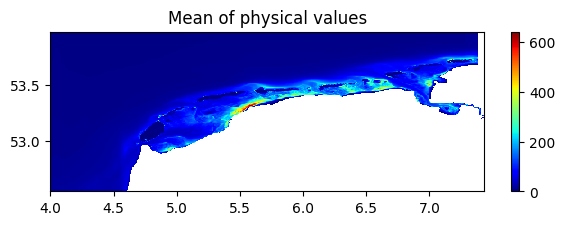

In [3]:
nlat = data.x.size
nlon = data.y.size
#plot the mean values of the whole year
mean_tgt_2018 = np.nanmean(data.__xarray_dataarray_variable__, axis=0)#.sel(time='2017')

#show the mean_tgt with color bar

vmin = np.nanmin(mean_tgt_2018)
vmax = min(10000,np.nanmax(mean_tgt_2018))

print(nlat,nlon)
print(vmin,vmax)
fig=plt.figure(figsize=[5+2, 5*(nlon/nlat)])
plt.pcolormesh(data.x, data.y,mean_tgt_2018, cmap='jet')
plt.colorbar()
plt.title('Mean of physical values')

In [4]:
#Note that here we  plus 0.1 in data_padded just to get positive values


# Step 1: Pad the 'y' dimension
new_shape_y = 240  # New size for 'y'
pad_size_y = new_shape_y - data.dims['y']  # Number of rows to add

# Create coordinates for the padding
# y_new = np.linspace(data.y.values[-1], data.y.values[-1] + (data.y.values[1] - data.y.values[0]) * pad_size_y, pad_size_y, endpoint=False)
y_new = np.linspace(data.y.values[-1] + (data.y.values[1] - data.y.values[0]), data.y.values[-1] + (data.y.values[1] - data.y.values[0]) * pad_size_y, pad_size_y, endpoint=False)


# Create an array of NaNs for padding
pad_array_y = np.full((data.dims['time'], pad_size_y, data.dims['x']), np.nan)

# Create a new DataArray for padding
pad_data_y = xr.DataArray(pad_array_y, dims=["time", "y", "x"], coords={"time": data.time, "y": y_new, "x": data.x})

# Concatenate the original data with the padding DataArray along 'y'
data_padded = xr.concat([data.__xarray_dataarray_variable__+0.1, pad_data_y], dim='y')

# Step 2: Crop the 'x' dimension
start_index_x = data.dims['x']-300  # Start index for 'x'
end_index_x = data.dims['x']  # End index for 'x'

# Crop the data
data_cropped = data_padded.isel(x=slice(start_index_x, end_index_x))

print(data_cropped)

# Create and Save a new Dataset
new_dataset = xr.Dataset({
    '__xarray_dataarray_variable__': data_cropped
})

print(new_dataset)




<xarray.DataArray '__xarray_dataarray_variable__' (time: 732, y: 240, x: 300)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
    

300 240
0.10000000000000016 642.2345719156724
(240, 300)


/tmp/ipykernel_4736/2646409216.py:6: RuntimeWarning: Mean of empty slice
  mean_tgt_2018 = np.nanmean(new_dataset.__xarray_dataarray_variable__, axis=0)#.sel(time='2018')


Text(0.5, 1.0, 'Mean of physical values')

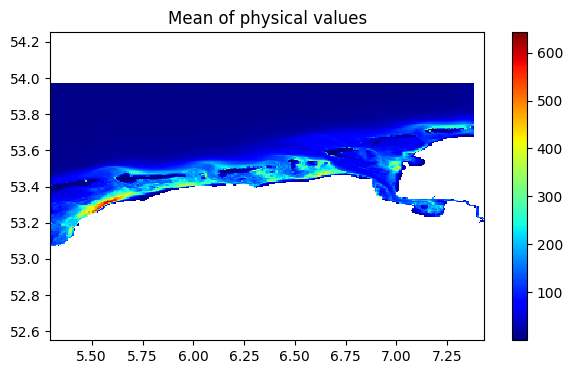

In [5]:
#plot the mean values, after padding and cropping to check size

nx = new_dataset.x.size
ny = new_dataset.y.size

mean_tgt_2018 = np.nanmean(new_dataset.__xarray_dataarray_variable__, axis=0)#.sel(time='2018')

#show the mean_tgt with color bar

vmin = np.nanmin(mean_tgt_2018)
vmax = min(10000,np.nanmax(mean_tgt_2018))

print(nx,ny)
print(vmin,vmax)
print(mean_tgt_2018.shape)
fig=plt.figure(figsize=[5+2, 5*(ny/nx)])
plt.pcolormesh(new_dataset.x, new_dataset.y,mean_tgt_2018, cmap='jet')
plt.colorbar()
plt.title('Mean of physical values')

In [6]:
# Rename the data variable and dimensions
new_dataset = new_dataset.rename({
    '__xarray_dataarray_variable__': 'SPM',
    'y': 'lat',
    'x': 'lon'
})

# # Step 3: Write the modified dataset to a new NetCDF file
new_dataset.to_netcdf('./Delft3Dmodel/data_Delft3D_crop_pad.nc')

In [7]:
#rescale to log 10, and replace NaN by Zero
data_SPM_nonan=np.where(np.isnan(new_dataset.SPM.values), 0., new_dataset.SPM.values)
print(f'data values before log10, min {np.min(data_SPM_nonan)} and max {np.max(data_SPM_nonan)}' )

print('np.unique(data_SPM_nonan) before log 10', np.unique(data_SPM_nonan))

new_dataset.SPM.values = np.log10((new_dataset.SPM.values+50)/10)

data_SPM_nonan=np.where(np.isnan(new_dataset.SPM.values), 0., new_dataset.SPM.values)
print(f'data values after log10, min {np.min(data_SPM_nonan)} and max {np.max(data_SPM_nonan)}' )

print(new_dataset)
new_dataset.to_netcdf('./Delft3Dmodel/GT_Delft3D__plus50_divided10_log10.nc')

data values before log10, min 0.0 and max 30668.675068190096
np.unique(data_SPM_nonan) before log 10 [0.00000000e+00 9.99999858e-02 9.99999999e-02 ... 2.20266591e+04
 2.39703538e+04 3.06686751e+04]
data values after log10, min 0.0 and max 3.4874024801425856
<xarray.Dataset>
Dimensions:  (time: 732, lat: 240, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-01-01
  * lat      (lat) float64 52.55 52.56 52.57 52.57 ... 54.23 54.24 54.24 54.25
  * lon      (lon) float64 5.3 5.307 5.315 5.322 ... 7.409 7.416 7.424 7.431
Data variables:
    SPM      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


300 240
0.699837725867242 1.6625585145752841
(240, 300)


/tmp/ipykernel_4736/3644310134.py:6: RuntimeWarning: Mean of empty slice
  mean_tgt_2018 = np.nanmean(new_dataset.sel(time='2017').SPM, axis=0)


Text(0.5, 1.0, 'Mean of log10 values')

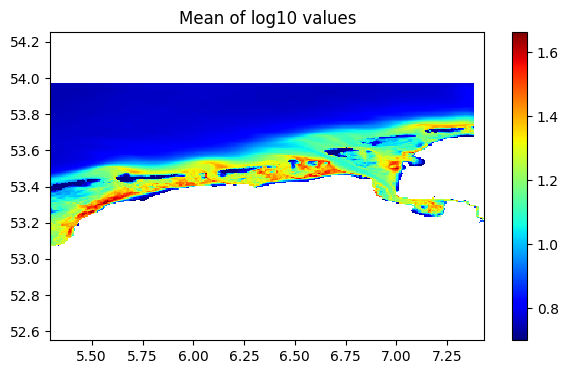

In [8]:
#plot the mean values after log 10

nx = new_dataset.lon.size
ny = new_dataset.lat.size

mean_tgt_2018 = np.nanmean(new_dataset.sel(time='2017').SPM, axis=0)

#show the mean_tgt with color bar

vmin = np.nanmin(mean_tgt_2018)
vmax = min(10000,np.nanmax(mean_tgt_2018))

print(nx,ny)
print(vmin,vmax)
print(mean_tgt_2018.shape)
fig=plt.figure(figsize=[5+2, 5*(ny/nx)])
plt.pcolormesh(new_dataset.lon, new_dataset.lat,mean_tgt_2018, cmap='jet')
plt.colorbar()
plt.title('Mean of log10 values')

In [61]:
########################
##### land mask ########
########################
mask = np.where(np.isnan(new_dataset.SPM.values), 0., 1.)
print('mask.shape',mask.shape)
nt = len(new_dataset.time)
print('nt: ', nt)
#print('mask: ', mask)
land_mask = np.float64(np.sum(mask==0,0)==nt)#axis=0 of the numpy.sum, land_mask shape (78,289) contains 0 and 1, 1 only at the place when all time-series x is NOT nan at that pixel
print('land_mask.shape',land_mask.shape)
land_mask[np.where(land_mask==0)] = np.nan
land_mask = xr.DataArray(land_mask,name="mask",coords=[new_dataset.lat,new_dataset.lon],dims=['lat','lon'])
print('land_mask after format as Xarray: ', land_mask)

#this 2 below is just to save the file containing land_mask
land_mask_file = './Delft3Dmodel/land_mask_Delft3D.nc'
land_mask.to_netcdf(land_mask_file)

mask.shape (732, 240, 300)
nt:  732
land_mask.shape (240, 300)
land_mask after format as Xarray:  <xarray.DataArray 'mask' (lat: 240, lon: 300)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lat      (lat) float64 52.55 52.56 52.57 52.57 ... 54.23 54.24 54.24 54.25
  * lon      (lon) float64 5.3 5.307 5.315 5.322 ... 7.409 7.416 7.424 7.431


In [10]:
#create obs_patches by removed patches 
##########################
#### Patch (from 0 to 50%) Obs. ####
##########################


# ~ lat_min = 52.5
# land_mask = land_mask.values#note that land_mask contains only 0 and 1

lon = new_dataset.lon
lat = new_dataset.lat

n_land_pix = np.nansum(land_mask)# sum of array elements over a given axis treating Not a Numbers (NaNs) as zero.==> number of 1-pixels
n_sea_pix = land_mask.size-n_land_pix# numbe of 0-pixels

np.random.seed(10)
for t in range(new_dataset.time.size):
    mask_patch = np.where(np.isnan(new_dataset.SPM[t].values),np.nan,1)#mask_patch contains only nan and 1, nan at places that SPM values is nan, and 1 otherwise

    #p_mv is the ratio of nan-pixels to sea-pixels, so if it's bigger than 0.75, then we need to cover more sea-pixels with nan-pixels
    p_mv = 1-np.nansum(mask_patch)/n_sea_pix# "np.nansum(mask_patch)/n_sea_pix" Oh, is it a problem here? n_sea_pix is to count #nan in all series, and np.nansum(mask_patch) is to count #NOT nan in the current x_t
    if p_mv <= .75:#i.e, np.nansum(mask_patch)/n_sea_pix bigger than 0.25!! Otherwise, no need to do anything since it is already too small (smaller than 0.25) !!!
        obj_p_mv = 1-.5*(np.nansum(mask_patch)/n_sea_pix)
        while p_mv <= obj_p_mv:#this one is always true since p_mv is always smaller than obj_p_mv
            half_patch_height = np.random.randint(2,10)
            idx_lat = np.random.randint(0,lat.size)
            idx_lon = np.random.randint(0,lon.size)
            mask_patch[np.max([0,idx_lat-half_patch_height]):np.min([lat.size,idx_lat+half_patch_height+1]),np.max([0,idx_lon-half_patch_height]):np.min([lon.size,idx_lon+half_patch_height+1])] = np.nan
            p_mv = 1-np.nansum(mask_patch)/n_sea_pix
                
    new_var = new_dataset.SPM[t].values
    new_var[np.where(np.isnan(mask_patch))] = np.nan

    new_dataset.SPM[t].values = new_var


new_dataset.to_netcdf('./Delft3Dmodel/Obs_patch_Delft3D_2016to2018.nc')

<xarray.Dataset>
Dimensions:  (time: 365, lat: 240, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * lat      (lat) float64 52.55 52.56 52.57 52.57 ... 54.23 54.24 54.24 54.25
  * lon      (lon) float64 5.3 5.307 5.315 5.322 ... 7.409 7.416 7.424 7.431
Data variables:
    SPM      (time, lat, lon) float64 ...
data_month.time[t] January 01, 2017
data_month.time[t] January 01, 2017
data_month.time[t] January 02, 2017
data_month.time[t] January 03, 2017
data_month.time[t] January 04, 2017
data_month.time[t] January 05, 2017
data_month.time[t] January 06, 2017
data_month.time[t] January 07, 2017
data_month.time[t] January 08, 2017
data_month.time[t] January 09, 2017
data_month.time[t] January 10, 2017
data_month.time[t] January 11, 2017
data_month.time[t] January 12, 2017
data_month.time[t] January 13, 2017
data_month.time[t] January 14, 2017
data_month.time[t] January 15, 2017
data_month.time[t] January 16, 2017
data_month.time[t] January 

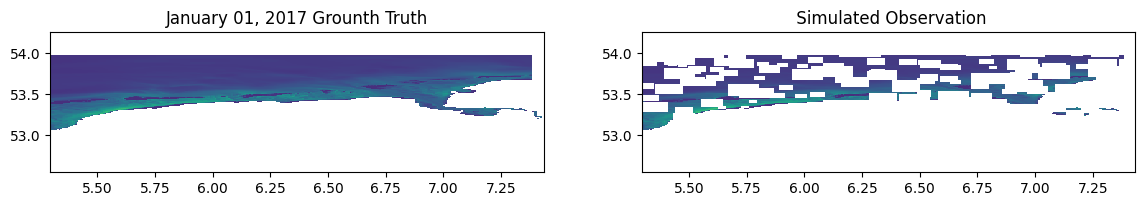

In [33]:
#visualize by an animation

import matplotlib.animation

# data =xr.open_dataset('./Obs_patch_2015to2018.nc')
GT = xr.open_dataset('./Delft3Dmodel/GT_Delft3D__plus50_divided10_log10.nc')
Obs = new_dataset



nt = data.time.size



#write a video of the data
path="./Delft3Dmodel/animation_"

years=["2017"]
for year in years:

    month="01"
    data_month=GT.sel(time=year)#+"-"+month)
    Obs_month=Obs.sel(time=year)#+"-"+month)
    print(data_month)


    fig=plt.figure(figsize=[2*5+4, 5*(nlat/nlon)])
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)

    def animate(t):

        ax0.clear()
        ax1.clear()


        ax0.pcolormesh(data_month.lon, data_month.lat,data_month.SPM[t], vmin=0.3, vmax = 3.3)
        ax0.pcolormesh(data_month.lon,data_month.lat, land_mask, cmap='Greys')#, vmin=0, vmax = 2)
        ax0.set_title(data_month.time[t].dt.strftime("%B %d, %Y").values + " Grounth Truth")
        print("data_month.time[t]",data_month.time[t].dt.strftime("%B %d, %Y").values)

        ax1.pcolormesh(data_month.lon, data_month.lat,Obs_month.SPM[t], vmin=0.3, vmax = 3.3)
        ax1.pcolormesh(data_month.lon,data_month.lat, land_mask, cmap='Greys')#, vmin=0, vmax = 2)
        ax1.set_title(" Simulated Observation")

        
    ani=matplotlib.animation.FuncAnimation(fig, animate, frames=len(data_month.time))
    writer = matplotlib.animation.FFMpegWriter(fps=1)
    ani.save(path +year+"-"+".mp4", writer=writer)


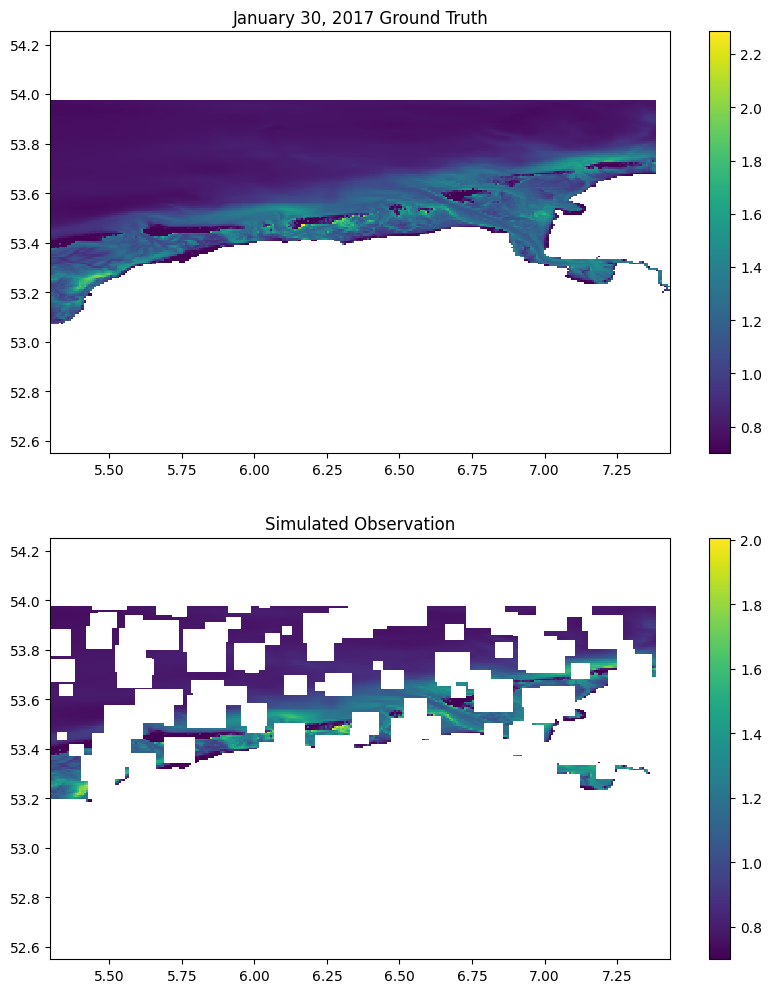

In [13]:
#plot several days only, instead of the animation on whole month

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[2*5, 5*(nlat/nlon)])

t = 29  # Example time index

# Plot for the Ground Truth
mappable0 = ax0.pcolormesh(data_month.lon, data_month.lat, data_month.SPM[t])
ax0.pcolormesh(data_month.lon, data_month.lat, land_mask, cmap='Greys')
ax0.set_title(data_month.time[t].dt.strftime("%B %d, %Y").values + " Ground Truth")
fig.colorbar(mappable0, ax=ax0)  # Create a colorbar for the first subplot

# Plot for the Simulated Observation
mappable1 = ax1.pcolormesh(data_month.lon, data_month.lat, Obs_month.SPM[t])
ax1.pcolormesh(data_month.lon, data_month.lat, land_mask, cmap='Greys')
ax1.set_title("Simulated Observation")
fig.colorbar(mappable1, ax=ax1)  # Create a colorbar for the second subplot

plt.show()  # Display the plot


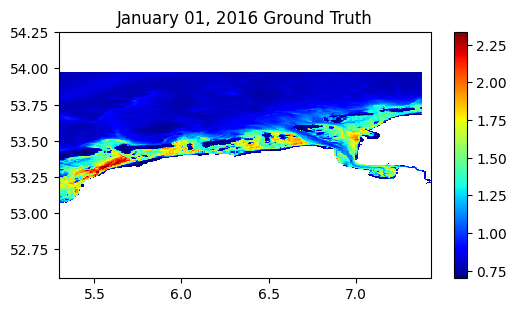

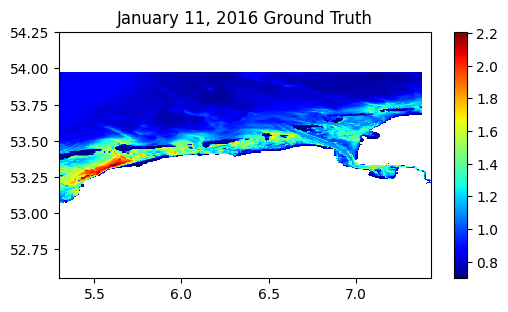

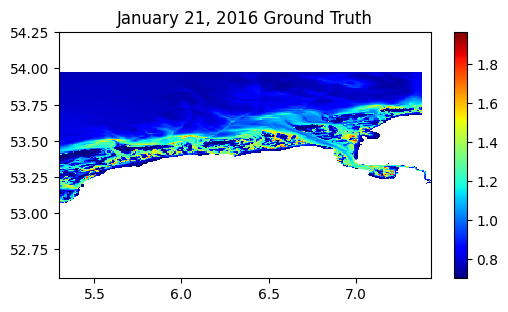

In [18]:
#draw some examples of the GrounthTruth
for i in range(0,30,10):
    fig, ax = plt.subplots(figsize=[4 + 2, 4 * (ny / nx)])  # Create a figure and an axes object
    c = ax.pcolormesh(GT.lon, GT.lat, GT.SPM[i], cmap='jet')  # Plot on the axes object
    ax.pcolormesh(GT.lon,GT.lat, land_mask, cmap='Greys')
    ax.set_title(GT.time[i].dt.strftime("%B %d, %Y").values + " Ground Truth")  # Set the title on the axes object
    fig.colorbar(c, ax=ax)  # Add a colorbar to the figure based on the plot

    plt.show()  # Display the plot

In [59]:
#compute metrics on test set

# data = xr.open_dataset(
#     "/home/t23nguye/Documents/Data_CMEMS/Delft3Dmodel/output_4DVarnet/2024-02-12/13-25-53/base_test_OSSE/"
#     + "test_data.nc"
# )

data = xr.open_dataset(
    "/home/t23nguye/Documents/Data_CMEMS/Delft3Dmodel/output_4DVarnet/2024-02-13/10-24-55/base_OSSE_train_bg/train_OSSE_from_beginning_/"
    + "test_data.nc"
)

data=data.sel(time=slice("2017-11-01","2017-12-31"))
print(data)
mask_no_obs_kd = (1 - np.isnan(data.tgt)) * (
    np.isnan(data.inp)
)  # (1 - np.isnan(data.tgt)) equal to 1 if there is observation and 0 if there is no observation, np.isnan(data.inp)
# equal to 1 if there is cloud coverage (including the simulated cloud), so mask_no_obs_kd equal to 1 if there is observation and cloud coverage,
# so it means we measure only on pixels which are missing in the input compared to groundtruth
mask_no_obs_kd = np.where(mask_no_obs_kd == 1, True, False)
print("mask_no_obs_kd.shape", mask_no_obs_kd.shape)

predict_dineof_kd = data.out.values[mask_no_obs_kd]
obs_kd = data.tgt.values[mask_no_obs_kd]
print("data.tgt shape", data.tgt.shape)
print("obs_kd shape", obs_kd.shape)

nlat = data.lat.size
nlon = data.lon.size

<xarray.Dataset>
Dimensions:  (time: 61, lat: 240, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-01 2017-11-02 ... 2017-12-31
  * lat      (lat) float64 52.55 52.56 52.57 52.57 ... 54.23 54.24 54.24 54.25
  * lon      (lon) float64 5.3 5.307 5.315 5.322 ... 7.409 7.416 7.424 7.431
Data variables:
    inp      (time, lat, lon) float64 ...
    tgt      (time, lat, lon) float64 ...
    out      (time, lat, lon) float64 ...
mask_no_obs_kd.shape (61, 240, 300)
data.tgt shape (61, 240, 300)
obs_kd shape (734286,)


In [60]:
#compute RMSE and RE for as a whole dataset

rmse = np.sqrt(np.nanmean((obs_kd - predict_dineof_kd) ** 2))
RE = (
    np.nanmean(
        (np.abs(10**obs_kd - 10**predict_dineof_kd) / 10**obs_kd)
    )
    * 100
)
print(f"rmse {rmse}  and  RE {RE}")

rmse 0.013374672495524357  and  RE 1.6991141823722073


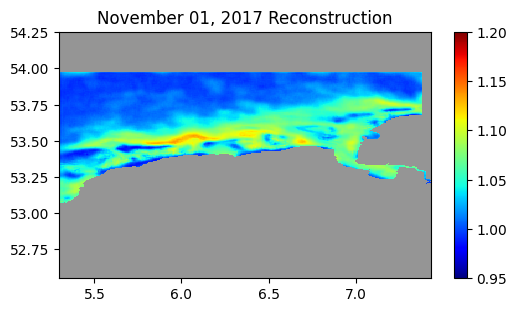

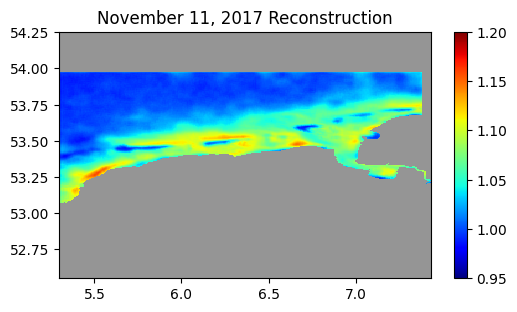

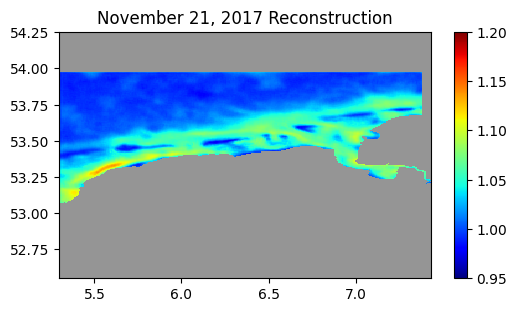

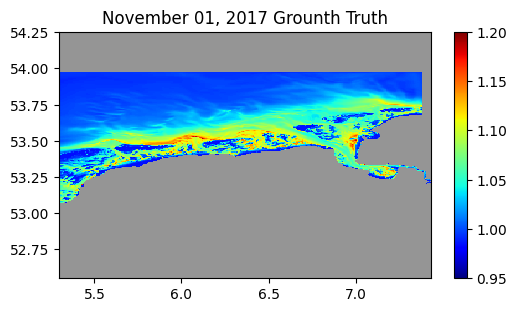

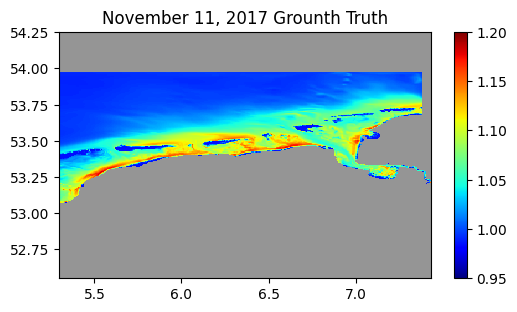

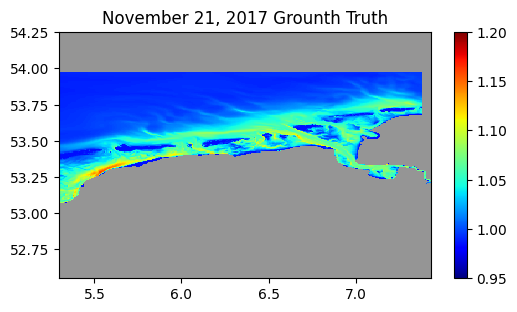

In [51]:
rang_min=0
rang_max=rang_min+30

v_min=0.95#np.min(data.tgt[rang_min:rang_max])
v_max=1.2#np.max(data.tgt[rang_min:rang_max])
#draw some examples of the Reconstruction
for i in range(rang_min,rang_max,10):
    fig, ax = plt.subplots(figsize=[4 + 2, 4 * (ny / nx)])  # Create a figure and an axes object
    c = ax.pcolormesh(data.lon, data.lat, data.out[i], cmap='jet', vmin=v_min, vmax = v_max)  # Plot on the axes object
    ax.pcolormesh(data.lon,data.lat, land_mask, cmap='Greys', vmin=0, vmax = 2)
    ax.set_title(data.time[i].dt.strftime("%B %d, %Y").values + " Reconstruction")  # Set the title on the axes object
    fig.colorbar(c, ax=ax)  # Add a colorbar to the figure based on the plot

    plt.show()  # Display the plot

#draw some examples of the Grouth Truth in test_data.nc file
for i in range(rang_min,rang_max,10):
    fig, ax = plt.subplots(figsize=[4 + 2, 4 * (ny / nx)])  # Create a figure and an axes object
    c = ax.pcolormesh(data.lon, data.lat, data.tgt[i], cmap='jet', vmin=v_min, vmax = v_max)  # Plot on the axes object
    ax.pcolormesh(data.lon,data.lat, land_mask, cmap='Greys', vmin=0, vmax = 2)
    ax.set_title(data.time[i].dt.strftime("%B %d, %Y").values + " Grounth Truth")  # Set the title on the axes object
    fig.colorbar(c, ax=ax)  # Add a colorbar to the figure based on the plot

    plt.show()  # Display the plot

<xarray.Dataset>
Dimensions:  (time: 5, lat: 240, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-01-05
  * lat      (lat) float64 52.55 52.56 52.57 52.57 ... 54.23 54.24 54.24 54.25
  * lon      (lon) float64 5.3 5.307 5.315 5.322 ... 7.409 7.416 7.424 7.431
Data variables:
    inp      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tgt      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    out      (time, lat, lon) float64 1.3 1.322 1.33 1.329 ... 1.344 1.326 1.293
data_month.time[t] January 01, 2017
data_month.time[t] January 01, 2017
data_month.time[t] January 02, 2017
data_month.time[t] January 03, 2017
data_month.time[t] January 04, 2017
data_month.time[t] January 05, 2017
data_month.time[t] January 01, 2017


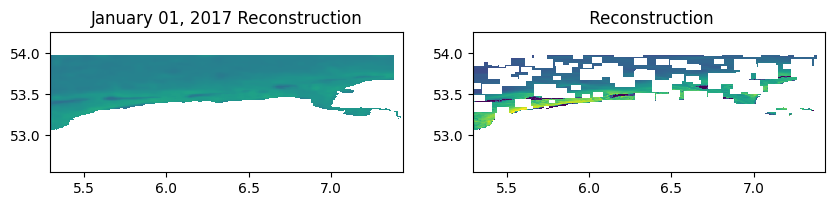

In [107]:
np.unique(data.out)

#write a video of the data
path="./Delft3Dmodel/output_4DVarnet/animation_ouput_"

year="2017"


month="01"
# Define start and end dates for the first 5 days of the month
start_date = f"{year}-{month}-01"
end_date = f"{year}-{month}-05"

# Select the data for the first 5 days of the month
data_month = data.sel(time=slice(start_date, end_date))
Obs_month = Obs.sel(time=slice(start_date, end_date))
print(data_month)


fig=plt.figure(figsize=[2*5, 5*(nlat/nlon)])
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)

def animate(t):

    ax0.clear()
    ax1.clear()


    ax0.pcolormesh(data_month.lon, data_month.lat,data_month.out[t], vmin=0.3, vmax = 3.3)
    ax0.pcolormesh(data_month.lon,data_month.lat, land_mask, cmap='Greys')#, vmin=0, vmax = 2)
    ax0.set_title(data_month.time[t].dt.strftime("%B %d, %Y").values + " Reconstruction")
    print("data_month.time[t]",data_month.time[t].dt.strftime("%B %d, %Y").values)

    ax1.pcolormesh(data_month.lon, data_month.lat,Obs_month.SPM[t], vmin=0.3, vmax = 3.3)
    ax1.pcolormesh(data_month.lon,data_month.lat, land_mask, cmap='Greys')#, vmin=0, vmax = 2)

    ax1.set_title(" Reconstruction")

        
ani=matplotlib.animation.FuncAnimation(fig, animate, frames=len(data_month.time))
writer = matplotlib.animation.FFMpegWriter(fps=1)
ani.save(path +year+"-"+".mp4", writer=writer)